In [35]:

import os
import torch
import numpy as np
import scipy.stats
from collections import defaultdict
from torch.distributions import constraints

import pyro
import pyro.distributions as dist

from pyro import poutine
from pyro.infer.autoguide import AutoDelta
from pyro.optim import Adam
from pyro.infer import SVI, TraceEnum_ELBO, config_enumerate, infer_discrete
from pyro.util import ignore_jit_warnings

pyro.clear_param_store()
pyro.set_rng_seed(1)


In [2]:

import pandas as pd
import numpy as np
from sklearn.mixture import GaussianMixture
from scipy.stats import skew
from scipy.spatial.distance import cityblock

rtdata = pd.read_csv('mcfrt.csv')
rtdata = rtdata.query('chr == "1"')
rtdata


,chr,start,end,gc,mcf7rt,bin_size
0,1,1000000,1500000,0.598330,81.441980,500000
1,1,1500000,2000000,0.539496,79.131013,500000
2,1,2000000,2500000,0.594508,78.557313,500000
3,1,3000000,3500000,0.584570,70.388076,500000
4,1,4000000,4500000,0.482572,48.663092,500000
...,...,...,...,...,...,...
423,1,246000000,246500000,0.404142,47.146415,500000
424,1,246500000,247000000,0.428546,70.978030,500000
425,1,247000000,247500000,0.425162,58.722962,500000
426,1,247500000,248000000,0.400436,30.497224,500000


In [3]:

import matplotlib.pyplot as plt
import seaborn as sns

rtdata['norm_mcf7rt'] = (rtdata['mcf7rt'] - rtdata['mcf7rt'].min()) / (rtdata['mcf7rt'].max() - rtdata['mcf7rt'].min())

sns.lineplot(x='start', y='norm_mcf7rt', data=rtdata)


<AxesSubplot:xlabel='start', ylabel='norm_mcf7rt'>

In [4]:

starts = rtdata['start'].values
rt = rtdata['norm_mcf7rt'].values
num_cells = 170
num_loci = 400

cn = np.ones((rt.shape[0], num_cells)) * 2

starts = starts[:num_loci]
rt = torch.tensor(rt[:num_loci])
cn = torch.tensor(cn[:num_loci, :])

# add a CNA for 30 cells in the first 30 bins
cn[:30, :30] = 1

### Play around with using true `cn` to create a reasonable prior for `cn_prob`

In [5]:
weight = 10.
cn_prior = torch.ones(num_loci, num_cells, 13)
for i in range(num_loci):
    for n in range(num_cells):
        state = int(cn[i, n].numpy())
        cn_prior[i, n, state] = weight
cn_prior[0,0]

tensor([ 1., 10.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])

In [6]:
diploid_cn_prior = torch.ones(num_loci, num_cells, 13)
diploid_cn_prior[:, :, 2] = 10.

### Define generative model

 Trace Shapes:          
  Param Sites:          
          nb_r         1
 Sample Sites:          
        a dist       1 |
         value       1 |
      log_prob       1 |
num_cells dist         |
         value     170 |
      log_prob         |
        t dist     170 |
         value     170 |
      log_prob     170 |
        u dist     170 |
         value     170 |
      log_prob     170 |
 num_loci dist         |
         value     400 |
      log_prob         |
      rep dist 400 170 |
         value 400 170 |
      log_prob 400 170 |
    reads dist 400 170 |
         value 400 170 |
      log_prob 400 170 |


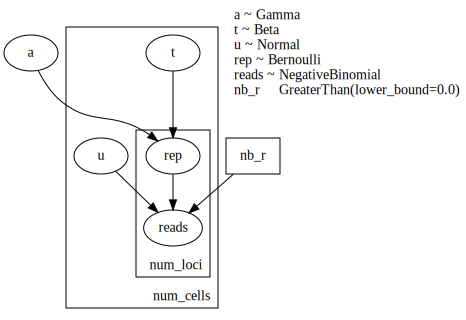

In [7]:

@config_enumerate
def model_S(cn0=None, rt0=None, num_cells=None, num_loci=None, data=None, cn_prior=None, t_alpha_prior=None, t_beta_prior=None):
    assert (num_cells is None) != (data is None)

    if data is not None:
        num_loci, num_cells = data.shape
    elif cn0 is not None:
        num_loci, num_cells = cn0.shape

    # controls the consistency of replicating on time
    a = pyro.sample('a', dist.Gamma(torch.tensor([2.]), torch.tensor([0.2])))
    
    # negative binomial dispersion
    nb_r = pyro.param('nb_r', torch.tensor([10000.0]), constraint=constraints.positive)
    
    if rt0 is not None:
        # fix rt as constant when input into model
        rt = rt0
    else:
        with pyro.plate('num_loci0', num_loci):
            # bulk replication timing profile
            rt = pyro.sample('rt', dist.Normal(torch.ones(num_loci)*0.5, 0.1))
    
    # fix cn as constant when input into model
    if cn0 is not None:
        cn = cn0

    with pyro.plate('num_cells', num_cells):

        # per cell replication time
        # draw from prior if provided
        if (t_alpha_prior is not None) and (t_beta_prior is not None):
            t = pyro.sample('t', dist.Beta(t_alpha_prior, t_beta_prior))
        else:
            t = pyro.sample('t', dist.Beta(torch.tensor([1.5]), torch.tensor([1.5])))
        
        # per cell reads per copy per bin
        # u should be inversely related to t and cn, positively related to reads
        if data is not None:
            if cn0 is not None:
                cell_ploidies = torch.mean(cn0.type(torch.float32), dim=0)
            elif cn_prior is not None:
                temp_cn0 = torch.argmax(cn_prior, dim=2).type(torch.float32)
                cell_ploidies = torch.mean(temp_cn0, dim=0)
            else:
                cell_ploidies = torch.ones(num_cells) * 2.
            u_guess = torch.mean(data.type(torch.float32), dim=0) / ((1 + t) * cell_ploidies)
        else:
            u_guess = torch.tensor([70.])
        
        u_stdev = u_guess / 10.
    
        u = pyro.sample('u', dist.Normal(u_guess, u_stdev))

        with pyro.plate('num_loci', num_loci):
            
            if cn0 is None:
                if cn_prior is None:
                    cn_prior = torch.ones(num_loci, num_cells, 13)
                # sample cn probabilities of each bin from Dirichlet
                cn_prob = pyro.sample('cn_prob', dist.Dirichlet(cn_prior))
                # sample cn state from categorical based on cn_prob
                cn = pyro.sample('cn', dist.Categorical(cn_prob))

            # per cell per bin late or early 
            t_diff = t.reshape(-1, num_cells) - rt.reshape(num_loci, -1)

            # probability of having been replicated
            p_rep = 1 / (1 + torch.exp(-a * t_diff))

            # binary replicated indicator
            rep = pyro.sample('rep', dist.Bernoulli(p_rep))

            # copy number accounting for replication
            rep_cn = cn * (1. + rep)

            # expected reads per bin per cell
            expected_reads = (u * rep_cn)

            nb_p = expected_reads / (expected_reads + nb_r)
            reads = pyro.sample('reads', dist.NegativeBinomial(nb_r, probs=nb_p), obs=data)

trace = poutine.trace(model_S).get_trace(cn, rt, num_cells=num_cells)
trace.compute_log_prob()
print(trace.format_shapes())
pyro.render_model(model_S, model_args=(cn, rt, num_cells), 
                  render_distributions=True, render_params=True)

 Trace Shapes:             
  Param Sites:             
          nb_r         1   
 Sample Sites:             
        a dist       1 |   
         value       1 |   
      log_prob       1 |   
num_loci0 dist         |   
         value     400 |   
      log_prob         |   
       rt dist     400 |   
         value     400 |   
      log_prob     400 |   
num_cells dist         |   
         value     170 |   
      log_prob         |   
        t dist     170 |   
         value     170 |   
      log_prob     170 |   
        u dist     170 |   
         value     170 |   
      log_prob     170 |   
 num_loci dist         |   
         value     400 |   
      log_prob         |   
  cn_prob dist 400 170 | 13
         value 400 170 | 13
      log_prob 400 170 |   
       cn dist 400 170 |   
         value 400 170 |   
      log_prob 400 170 |   
      rep dist 400 170 |   
         value 400 170 |   
      log_prob 400 170 |   
    reads dist 400 170 |   
         value 400 1

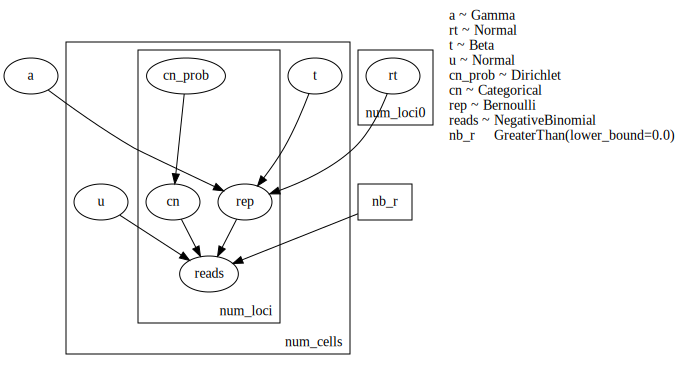

In [8]:
trace = poutine.trace(model_S).get_trace(None, num_cells=num_cells, num_loci=num_loci)
trace.compute_log_prob()
print(trace.format_shapes())
pyro.render_model(model_S, model_args=(None, None, num_cells, num_loci), 
                  render_distributions=True, render_params=True)

### Simulate and visualize data

In [9]:

# Simulate conditioned on a, get reads, replication timing etc

pyro.clear_param_store()

conditioned_model = poutine.condition(
    model_S,
    data={
        'a': torch.tensor([10.]),
    })

model_trace = pyro.poutine.trace(conditioned_model)

samples = model_trace.get_trace(cn, rt, num_cells=num_cells)

t = samples.nodes['t']['value']
a = samples.nodes['a']['value']
u = samples.nodes['u']['value']
nb_r = samples.nodes['nb_r']['value']

t_diff = t.reshape(-1, num_cells) - rt.reshape(num_loci, -1)
p_rep = 1 / (1 + torch.exp(-a * t_diff))

rep = samples.nodes['rep']['value']

rep_cn = cn * (1. + rep)

reads = samples.nodes['reads']['value']


/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


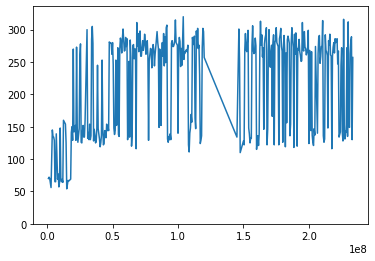

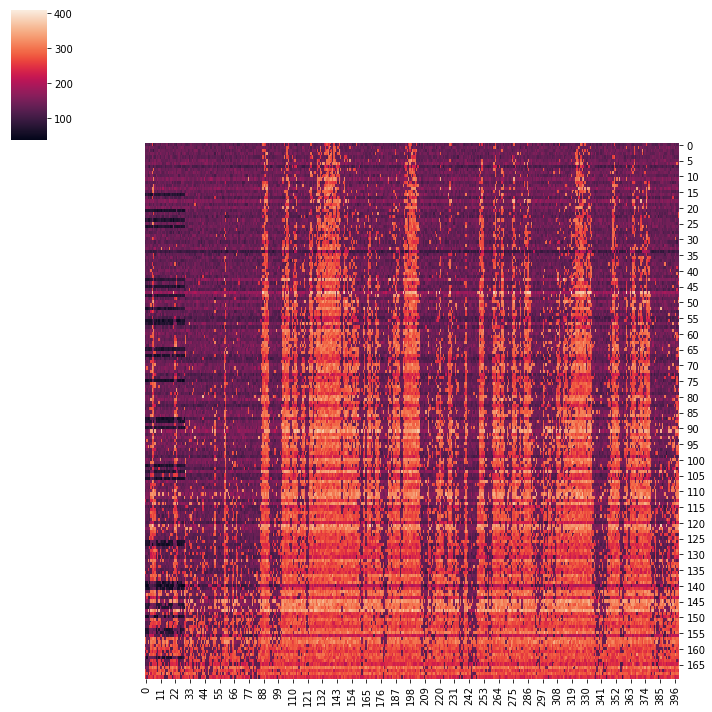

In [10]:
# Visualize one cell and matrix

sns.lineplot(starts, reads[:, 1])
plt.ylim((0, 1.05 * reads[:, 1].max()))

sns.clustermap(reads.numpy().astype(float).T[np.argsort(t), :], col_cluster=False, row_cluster=False)

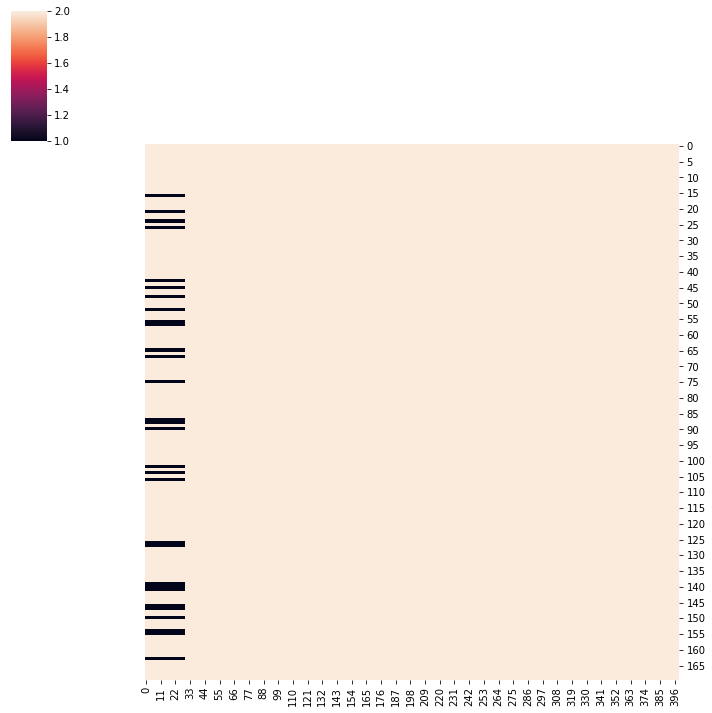

In [11]:
# visualize the true copy number heatmap
sns.clustermap(cn.numpy().astype(float).T[np.argsort(t), :], col_cluster=False, row_cluster=False)
plt.show()

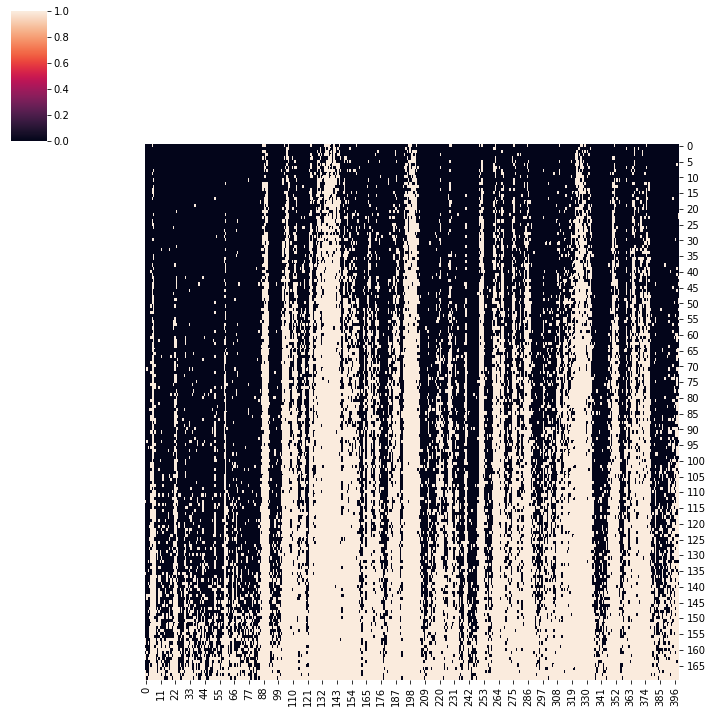

In [12]:
# visualize the true replication heatmap
sns.clustermap(rep.numpy().astype(float).T[np.argsort(t), :], col_cluster=False, row_cluster=False)
plt.show()

/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


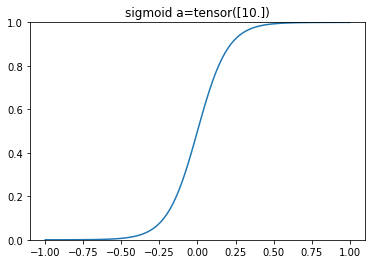

In [13]:
def plot_sigmoid(a):
    x = np.linspace(-1, 1, 101)
    y = 1 / (1 + np.exp(-a * x))

    sns.lineplot(x, y)
    plt.title(f'sigmoid a={a}')
    plt.ylim((0, 1))

plot_sigmoid(samples.nodes['a']['value'].detach())


### Normalize each cell to the same total number of reads

In [14]:
reads_per_cell = torch.mean(reads) * num_loci
reads_norm = (reads / torch.sum(reads, 0)) * reads_per_cell
reads_norm = reads_norm.type(torch.int64)

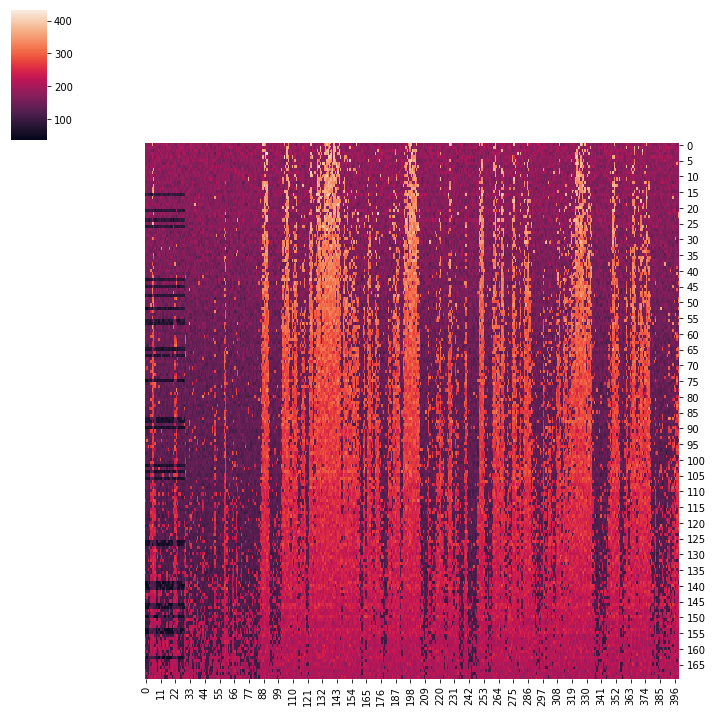

In [15]:
sns.clustermap(reads_norm.numpy().astype(float).T[np.argsort(t), :], col_cluster=False, row_cluster=False)
plt.show()

In [16]:
cn = cn.type(torch.float32)
reads = reads.type(torch.float32)
reads_norm = reads_norm.type(torch.float32)
cn_prior = cn_prior.type(torch.float32)
diploid_cn_prior = diploid_cn_prior.type(torch.float32)
rt = rt.type(torch.float32)
t = t.type(torch.float32)

### Try to find a good prior for each cell's `t` param

Start by computing relative abundance of 2-state GMM clusters where input is CN-normalized read depth

In [17]:
torch.argmax(cn_prior, dim=2)

tensor([[1, 1, 1,  ..., 2, 2, 2],
        [1, 1, 1,  ..., 2, 2, 2],
        [1, 1, 1,  ..., 2, 2, 2],
        ...,
        [2, 2, 2,  ..., 2, 2, 2],
        [2, 2, 2,  ..., 2, 2, 2],
        [2, 2, 2,  ..., 2, 2, 2]])

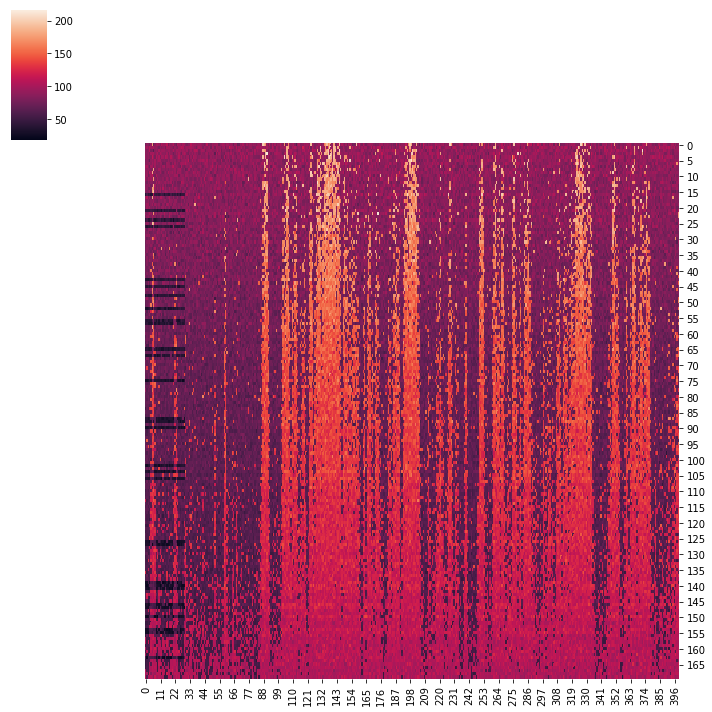

In [18]:
# normalize read depth by true CN
reads_norm_by_cn = reads_norm / torch.argmax(diploid_cn_prior, dim=2)

sns.clustermap(reads_norm_by_cn.numpy().astype(float).T[np.argsort(t), :], col_cluster=False, row_cluster=False)
plt.show()

In [19]:
def manhattan_binarization(X, MEAN_GAP_THRESH=0.7, EARLY_S_SKEW_THRESH=0.2, LATE_S_SKEW_THRESH=-0.2):
    # center and scale the data
    X = (X - np.mean(X)) / np.std(X)
    
    # fit a 2-state GMM to the data
    gm = GaussianMixture(n_components=2, random_state=0)
    states = gm.fit_predict(X)
    
    # use GMM means to assign binary values for thresholding
    mean_0 = gm.means_[0][0]
    mean_1 = gm.means_[1][0]

    # find the distance between the two means for each state
    mean_gap = abs(mean_0 - mean_1)

    # assume means denote binary values
    binary_0 = min(mean_0, mean_1)
    binary_1 = max(mean_0, mean_1)
    
    X = X.flatten()
    
    # use skew to define the binary values if means are close together
    if mean_gap < MEAN_GAP_THRESH:
        cell_skew = skew(X)
        print('cell_skew', cell_skew)
        # positive skew indicates early S-phase
        if cell_skew > EARLY_S_SKEW_THRESH:
            binary_0 = np.percentile(X, 50)
            binary_1 = np.percentile(X, 95)
        # negative skew indicates late S-phase
        elif cell_skew < LATE_S_SKEW_THRESH:
            binary_0 = np.percentile(X, 5)
            binary_1 = np.percentile(X, 50)
        # assume mid-S when skew is neutral
        else:
            binary_0 = np.percentile(X, 25)
            binary_1 = np.percentile(X, 75)

    # now that binary values are selected, I must compute the Manhattan distance
    # between binarized data and X for 100 different thresholds
    threshs = np.linspace(binary_0, binary_1, 100)
    lowest_dist = np.inf
    best_t = None
    manhattan_dists = []
    for t in threshs:
        # set values to binary_1 when above t, to binary_0 when below t
        B = np.where(X>t, binary_1, binary_0)
        # compute Manhattan distance between two vectors
        dist = cityblock(X, B)
        manhattan_dists.append(dist)
        if dist < lowest_dist:
            lowest_dist = dist
            best_t = t

    # binarize X based on the best threshold
    cell_rt = np.where(X>best_t, 1, 0)
    # compute fraction of replicated bins (cell's time within s-phase)
    frac_rt = sum(cell_rt) / len(cell_rt)
    
    return cell_rt, frac_rt



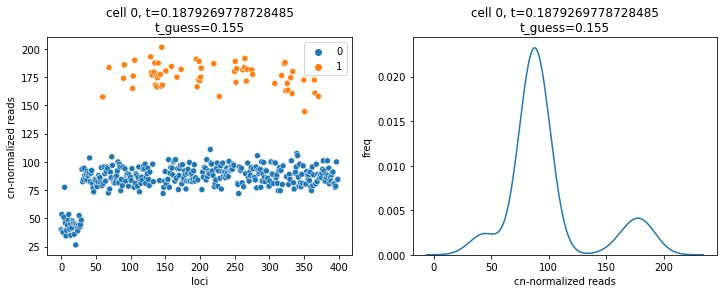

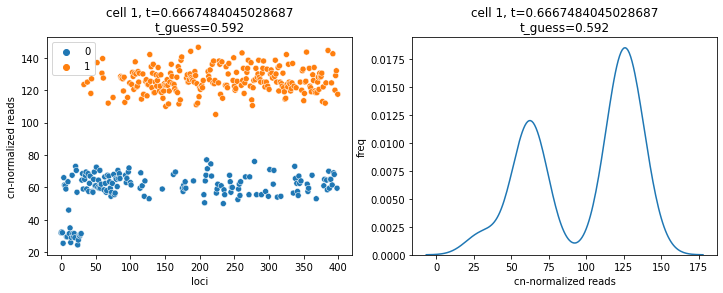

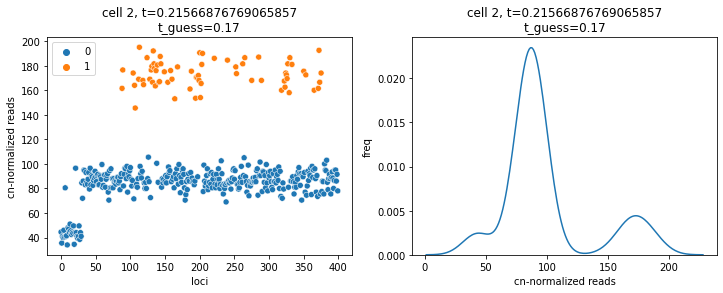

In [20]:
t_alpha_prior = torch.zeros(num_cells)
t_beta_prior = torch.zeros(num_cells)
gamma = 6
for i in range(num_cells):
    cell_profile = reads_norm_by_cn[:, i]
    cell_t = t[i]
    cell_rep_profile = rep[:, i]
    
    X = cell_profile.numpy().reshape(-1, 1)
#     gmm2 = GaussianMixture(n_components=2).fit(X)
#     y_pred2 = gmm2.predict(X)
    
#     # make sure state==1 represents replicated and state==0 unreplicated
#     if gmm2.means_[0] > gmm2.means_[1]:
#         y_pred2 = np.abs(y_pred2 - 1)
    
    y_pred2, t_guess = manhattan_binarization(X)
    
#     t_guess = sum(y_pred2) / len(y_pred2)
    alpha = t_guess * gamma
    beta = gamma - alpha
    t_alpha_prior[i] = alpha
    t_beta_prior[i] = beta
    
    if i < 3:

        fig, ax = plt.subplots(1, 2, figsize=(12, 4))

        sns.scatterplot(x=torch.arange(0, num_loci), y=cell_profile, hue=y_pred2, ax=ax[0])
        ax[0].set_xlabel('loci')
        ax[0].set_ylabel('cn-normalized reads')
        ax[0].set_title('cell {}, t={}\nt_guess={}'.format(i, cell_t, round(t_guess, 3)))

        sns.kdeplot(x=cell_profile, ax=ax[1])
        ax[1].set_xlabel('cn-normalized reads')
        ax[1].set_ylabel('freq')
        ax[1].set_title('cell {}, t={}\nt_guess={}'.format(i, cell_t, round(t_guess, 3)))

        plt.show()



In [21]:
t_alpha_prior

tensor([0.9300, 3.5550, 1.0200, 0.6900, 2.8200, 1.8450, 3.7050, 3.9900, 2.4900,
        1.8150, 1.6200, 2.3250, 4.8750, 2.8950, 3.8250, 2.1450, 1.5000, 4.1700,
        4.0200, 1.3800, 1.7700, 2.1750, 2.8350, 4.4400, 2.4450, 2.7000, 4.1400,
        3.9300, 4.5150, 0.8550, 1.7850, 2.7300, 1.8600, 2.3400, 5.3850, 2.1900,
        4.5900, 0.5100, 2.9550, 0.7800, 2.7450, 0.3000, 1.2750, 2.3700, 2.5500,
        0.7950, 3.3750, 3.7950, 5.2500, 5.1000, 1.0200, 4.9050, 3.4200, 2.8200,
        3.6750, 1.3500, 4.9800, 3.9900, 0.8100, 1.4100, 2.3700, 3.0300, 2.0250,
        1.3050, 0.6000, 3.7050, 1.8900, 5.0250, 3.3450, 2.7000, 2.6100, 2.2950,
        4.3950, 2.4750, 1.2300, 3.9450, 2.3100, 1.0950, 3.3450, 4.2750, 1.3500,
        2.4750, 3.4050, 4.0200, 3.3750, 0.9000, 1.0800, 0.6750, 2.0550, 2.2350,
        4.0650, 0.5250, 2.7150, 5.1300, 3.4200, 0.6900, 5.3250, 4.7700, 3.2100,
        1.9950, 2.9100, 1.8750, 1.3500, 2.2050, 0.7200, 0.6450, 0.4800, 3.5100,
        2.8050, 1.1850, 4.4550, 3.9150, 

### Infer all relevant params just taking `reads_norm` as input

In [22]:

optim = pyro.optim.Adam({'lr': 0.01, 'betas': [0.8, 0.99]})
elbo = TraceEnum_ELBO(max_plate_nesting=2)


In [23]:

conditioned_model = poutine.condition(
    model_S,
    data={
# Uncomment to condition on various hidden variables
#         'a': torch.tensor([10.]),
#         'rep': rep,
#         't': t,
#         'rt': rt,
#         'nb_r': nb_r,
#         'cn': cn,
#         'u': u
    })

guide = AutoDelta(
    poutine.block(conditioned_model, expose=['a', 'u', 't', 'nb_r', 'rt', 'cn_prob'], hide=['rep', 'cn']),
)
svi = SVI(conditioned_model, guide, optim, loss=elbo)


In [24]:

# Calculate initial loss

pyro.clear_param_store()

elbo.loss(conditioned_model, guide, data=reads_norm, cn_prior=diploid_cn_prior, t_alpha_prior=t_alpha_prior, t_beta_prior=t_beta_prior)


-180443.5625

In [25]:

# Learn the model and guide params

pyro.clear_param_store()

losses = []
for i in range(2000):
    loss = svi.step(data=reads_norm, cn_prior=diploid_cn_prior, t_alpha_prior=t_alpha_prior, t_beta_prior=t_beta_prior)
    losses.append(loss)
    print('.' if i % 80 else '\n', end='')



...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
.......................................

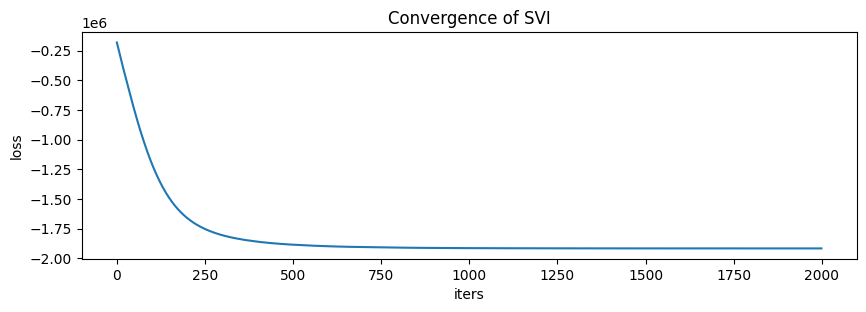

In [26]:

plt.figure(figsize=(10,3), dpi=100).set_facecolor('white')
plt.plot(losses)
plt.xlabel('iters')
plt.ylabel('loss')
# plt.yscale('log')
plt.title('Convergence of SVI');


### Visualize model output results for `rep` and `cn`

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 1., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 0., 1., 0.]], dtype=float32)

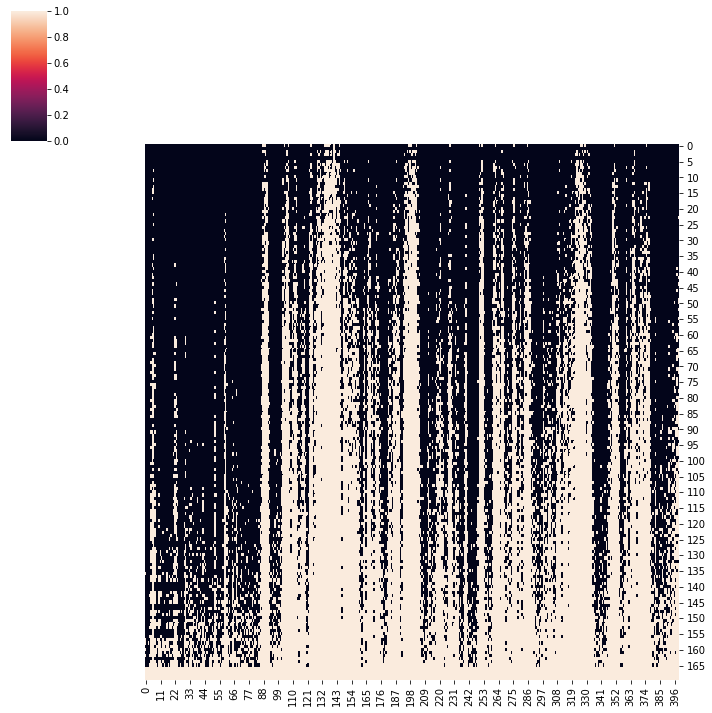

In [27]:

# Plot replicated state

guide_trace = poutine.trace(guide).get_trace(data=reads_norm, cn_prior=diploid_cn_prior, t_alpha_prior=t_alpha_prior, t_beta_prior=t_beta_prior)
trained_model = poutine.replay(conditioned_model, trace=guide_trace)

inferred_model = infer_discrete(
    trained_model, temperature=0,
    first_available_dim=-3)
trace = poutine.trace(inferred_model).get_trace(data=reads_norm, cn_prior=diploid_cn_prior, t_alpha_prior=t_alpha_prior, t_beta_prior=t_beta_prior)

sns.clustermap(trace.nodes["rep"]["value"].numpy().astype(float).T[np.argsort(t), :],
               col_cluster=False, row_cluster=False)

trace.nodes["rep"]["value"].numpy()


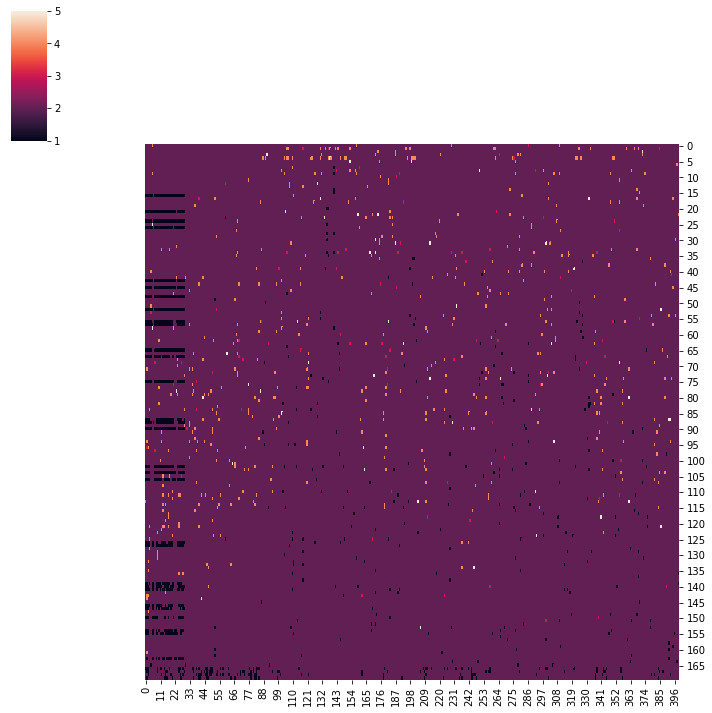

In [28]:
sns.clustermap(trace.nodes["cn"]["value"].numpy().astype(float).T[np.argsort(t), :],
               col_cluster=False, row_cluster=False)
plt.show()

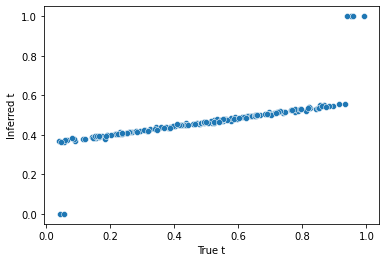

In [29]:

sns.scatterplot(
    x=t,
    y=trace.nodes["t"]["value"].detach().numpy().astype(float),
)
plt.xlabel('True t')
plt.ylabel('Inferred t')
plt.show()

In [30]:
model1_accuracy = 1.0 - (np.sum(abs(rep.numpy() - trace.nodes["rep"]["value"].numpy())) / (rep.shape[0] * rep.shape[1]))
model1_accuracy

0.9821176470588235

### Try to infer using model with HMM structure for CN

In [44]:
@config_enumerate
def model_S2(cn0=None, rt0=None, num_cells=None, num_loci=None, data=None, trans_mat=None, cn_prior=None, t_alpha_prior=None, t_beta_prior=None):
    with ignore_jit_warnings():
        if data is not None:
            num_loci, num_cells = data.shape
        elif cn0 is not None:
            num_loci, num_cells = cn0.shape
        assert num_cells is not None
        assert num_loci is not None

    # controls the consistency of replicating on time
    a = pyro.sample('expose_a', dist.Gamma(torch.tensor([2.]), torch.tensor([0.2])))
    
    # negative binomial dispersion
    nb_r = pyro.param('expose_nb_r', torch.tensor([10000.0]), constraint=constraints.positive)
    
    # transition probabilities for HMM
    if trans_mat is None:
        trans_mat = pyro.sample('expose_trans_prob',
                                dist.Dirichlet(0.99 * torch.eye(13) + 0.01).to_event(1))
    
    if rt0 is not None:
        # fix rt as constant when input into model
        rt = rt0
    else:
        with pyro.plate('num_loci0', num_loci):
            # bulk replication timing profile
            rt = pyro.sample('expose_rt', dist.Beta(torch.tensor([1.]), torch.tensor([1.])))

    with pyro.plate('num_cells', num_cells):
        
        # per cell replication time
        # draw from prior if provided
        if (t_alpha_prior is not None) and (t_beta_prior is not None):
            t = pyro.sample('expose_t', dist.Beta(t_alpha_prior, t_beta_prior))
        else:
            t = pyro.sample('expose_t', dist.Beta(torch.tensor([1.5]), torch.tensor([1.5])))
        
        # per cell reads per copy per bin
        # u should be inversely related to t and cn, positively related to reads
        if data is not None:
            if cn0 is not None:
                cell_ploidies = torch.mean(cn0.type(torch.float32), dim=0)
            elif cn_prior is not None:
                temp_cn0 = torch.argmax(cn_prior, dim=2).type(torch.float32)
                cell_ploidies = torch.mean(temp_cn0, dim=0)
            else:
                cell_ploidies = torch.ones(num_cells) * 2.
            u_guess = torch.mean(data.type(torch.float32), dim=0) / ((1 + t) * cell_ploidies)
        else:
            u_guess = torch.tensor([70.])
        
        u_stdev = u_guess / 10.
    
        u = pyro.sample('expose_u', dist.Normal(u_guess, u_stdev))

        # starting states for markov chain
        if cn0 is None:
            cn = 2

        for l in pyro.markov(range(num_loci)):

            # sample copy number states using HMM structure
            if cn0 is None:
                temp_cn_prob = trans_mat[cn]
                if cn_prior is not None:
                    temp_cn_prob = temp_cn_prob * cn_prior[l]
                cn = pyro.sample("cn_{}".format(l), dist.Categorical(temp_cn_prob),
                                 infer={"enumerate": "parallel"})
            else:
                # no need to sample cn when true cn0 is provided to the model
                cn = cn0[l]
                
            # per cell per bin late or early 
            time_diff = t.reshape(-1, num_cells) - rt[l]

            # probability of having been replicated
            p_rep = 1 / (1 + torch.exp(-a * time_diff))

            # binary replicated indicator
            rep = pyro.sample('rep_{}'.format(l), dist.Bernoulli(p_rep))
            
            # copy number accounting for replication
            rep_cn = cn * (1. + rep)

            # expected reads per bin per cell
            expected_reads = (u * rep_cn)

            nb_p = expected_reads / (expected_reads + nb_r)
            
            if data is not None:
                obs = data[l]
            else:
                obs = None
            
            reads = pyro.sample('reads_{}'.format(l), dist.NegativeBinomial(nb_r, probs=nb_p), obs=obs)


In [45]:
# build the transition matrix using cn
def build_trans_mat(cn, num_states=13):
    num_loci, num_cells = cn.shape
    trans_mat = torch.eye(num_states, num_states) + 10
    for i in range(num_cells):
        for j in range(1, num_loci):
            cur_state = int(cn[j, i])
            prev_state = int(cn[j-1, i])
            trans_mat[prev_state, cur_state] += 1
    return trans_mat

trans_mat = build_trans_mat(torch.argmax(cn_prior, dim=2))
diploid_trans_mat = build_trans_mat(torch.argmax(diploid_cn_prior, dim=2))

In [46]:
conditioned_model = poutine.condition(
    model_S2,
    data={
# Uncomment to condition on various hidden variables
#         'a': torch.tensor([10.]),
#         'rep': rep,
#         't': t,
#         'rt': rt,
#         'nb_r': nb_r,
#         'cn': cn,
#         'u': u
    })

# conditioned_model_G1 = poutine.condition(
#     model_S,
#     data=condition_dict
# )

guide = AutoDelta(
    poutine.block(conditioned_model, expose_fn=lambda msg: msg["name"].startswith("expose_"))
)

svi = SVI(conditioned_model, guide, optim, loss=elbo)


In [47]:
elbo.loss(conditioned_model, guide, data=reads_norm, cn_prior=diploid_cn_prior, trans_mat=diploid_trans_mat, 
          t_alpha_prior=t_alpha_prior, t_beta_prior=t_beta_prior)

353643.625

In [48]:
# Learn the model and guide params

pyro.clear_param_store()


losses = []
for i in range(2000):
    loss = svi.step(data=reads_norm, cn_prior=diploid_cn_prior, trans_mat=diploid_trans_mat, t_alpha_prior=t_alpha_prior, t_beta_prior=t_beta_prior)
    losses.append(loss)
    
    if i >= 100:
        loss_diff = abs(max(losses[-10:-1]) - min(losses[-10:-1])) / abs(losses[-1])
        if loss_diff < 5e-5:
            print('ELBO converged at iteration ' + str(i))
            break
    
    print('.' if i % 80 else '\n', end='')



...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
.......................................

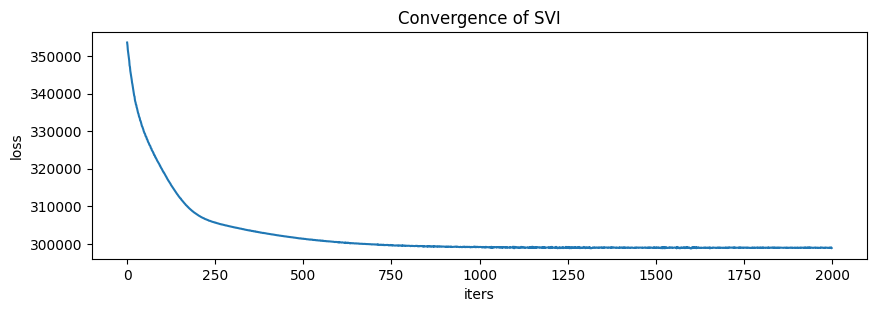

In [49]:
plt.figure(figsize=(10,3), dpi=100).set_facecolor('white')
plt.plot(losses)
plt.xlabel('iters')
plt.ylabel('loss')
# plt.yscale('log')
plt.title('Convergence of SVI');

In [50]:
# Extract fitted values

guide_trace = poutine.trace(guide).get_trace(data=reads_norm, cn_prior=diploid_cn_prior, 
                                             trans_mat=diploid_trans_mat, t_alpha_prior=t_alpha_prior, 
                                             t_beta_prior=t_beta_prior)
trained_model = poutine.replay(conditioned_model, trace=guide_trace)

inferred_model = infer_discrete(
    trained_model, temperature=0,
    first_available_dim=-2)
trace = poutine.trace(inferred_model).get_trace(data=reads_norm, cn_prior=diploid_cn_prior,
                                                trans_mat=diploid_trans_mat, t_alpha_prior=t_alpha_prior,
                                                t_beta_prior=t_beta_prior)

model_rep = torch.zeros(cn.shape)
model_cn = torch.zeros(cn.shape)
model_rep_cn = torch.zeros(cn.shape)
model_reads = torch.zeros(cn.shape)
for l in range(cn.shape[0]):
    temp_rep = trace.nodes['rep_{}'.format(l)]['value']
    temp_cn = trace.nodes['cn_{}'.format(l)]['value']
    temp_rep_cn = temp_cn * (1. + temp_rep)
    temp_reads = trace.nodes['reads_{}'.format(l)]['value']
    model_rep[l] = temp_rep
    model_cn[l] = temp_cn
    model_rep_cn[l] = temp_rep_cn
    model_reads[l] = temp_reads

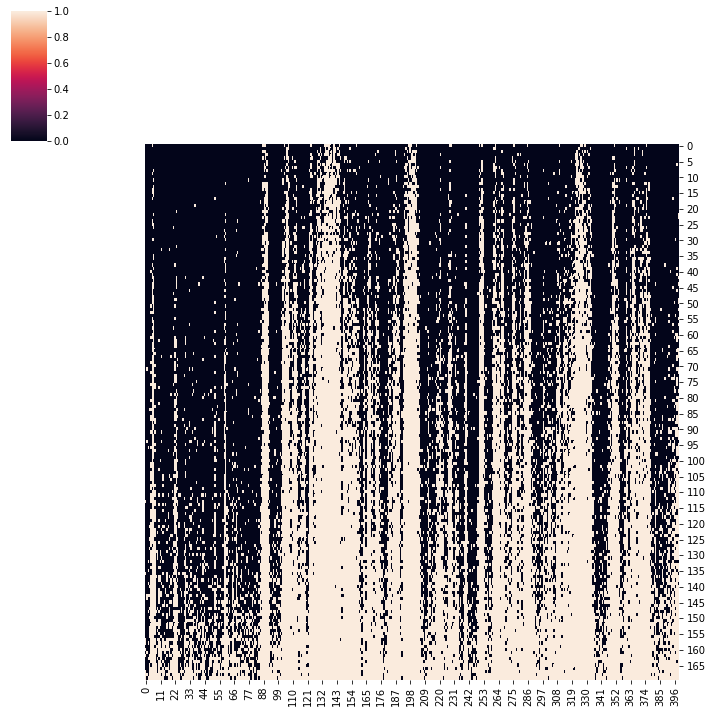

In [51]:
sns.clustermap(model_rep.numpy().astype(float).T[np.argsort(t), :],
               col_cluster=False, row_cluster=False)
plt.show()

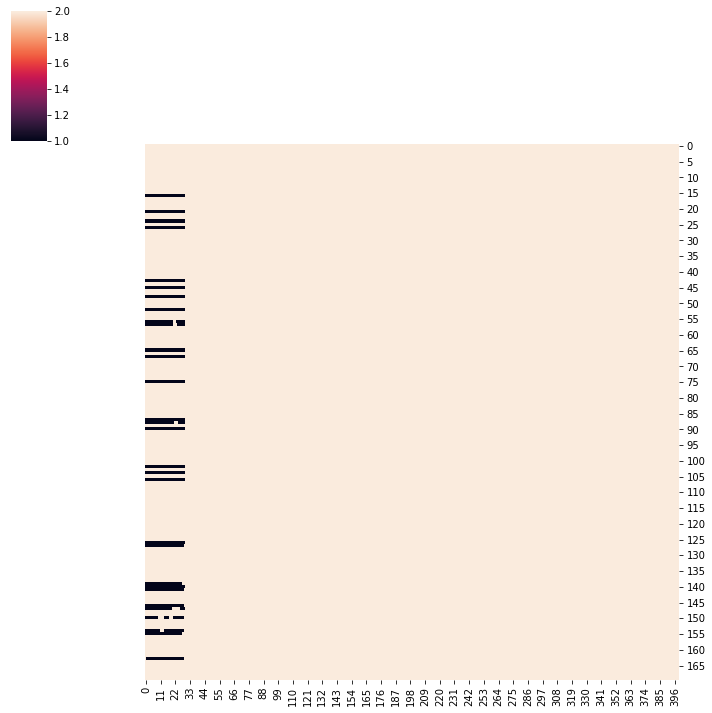

In [52]:
sns.clustermap(model_cn.numpy().astype(float).T[np.argsort(t), :],
               col_cluster=False, row_cluster=False)
plt.show()

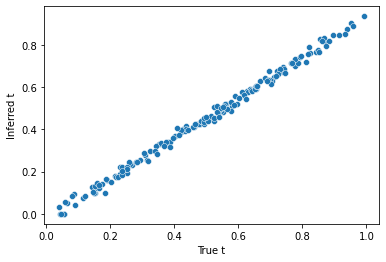

In [53]:
sns.scatterplot(
    x=t,
    y=trace.nodes["expose_t"]["value"].detach().numpy().astype(float),
)
plt.xlabel('True t')
plt.ylabel('Inferred t')
plt.show()

### Now try to infer with a model that treats all loci independently (agnostic to a bulk `rt` profile)

In [54]:
# u_guess = torch.mean(reads_norm) / (1.5 * torch.mean(cn))
# u_guess

In [55]:
# @config_enumerate
# def model_S2(cn_profiles, read_profiles=None, u_guess=61.0):
#     num_loci, num_cells = map(int, cn_profiles.shape)
#     if read_profiles is not None:
#         assert read_profiles.shape == cn_profiles.shape

#     # scale each cell's read count so that it sums to 1 million reads and do some reshaping
#     # epsilon = torch.finfo(torch.float64).eps
    
#     alphas = torch.ones(num_loci, num_cells)
#     betas = torch.ones(num_loci, num_cells)
    
#     # draw true read count from Poisson distribution
#     with pyro.plate("cells", num_cells):
#         # per cell reads per copy scaling factor for each bin
#         u = pyro.sample("expose_u", dist.Normal(torch.ones(num_cells)*u_guess, torch.tensor([u_guess/10.])))
#         with pyro.plate("loci", num_loci):
#             # draw each bin's replication probability from Beta
#             prob_replicated = pyro.sample("expose_rt_state_prob", dist.Beta(alphas, betas))
#             # draw replicated status from Bernoulli
#             replicated = pyro.sample("rt_state", dist.Bernoulli(prob_replicated))
#             # double the expected read count in bins that have been replicated
#             rep_cn = cn_profiles * (1 + replicated)
            
#             # negative binomial dispersion
#             nb_r = pyro.param('expose_nb_r', torch.tensor([10000.0]), constraint=constraints.positive)

#             # expected reads per bin per cell
#             expected_reads = (u * rep_cn)

#             nb_p = expected_reads / (expected_reads + nb_r)
#             reads = pyro.sample('reads', dist.NegativeBinomial(nb_r, probs=nb_p), obs=read_profiles)
    
#     return reads

# pyro.render_model(model_S2, model_args=(cn, reads, u_guess), 
#                   render_distributions=True, render_params=True)

In [56]:
# optim_2 = pyro.optim.Adam({'lr': 0.01, 'betas': [0.8, 0.99]})
# elbo_2 = TraceEnum_ELBO(max_plate_nesting=2)

# guide_2 = AutoDelta(poutine.block(model_S2, expose_fn=lambda msg: msg["name"].startswith("expose_")))
# svi_2 = SVI(model_S2, guide_2, optim_2, loss=elbo_2)

In [57]:
# cn.dtype, reads.dtype

In [58]:
# u_guess = u_guess.type(torch.float32)

In [59]:
# print('Start Inference.')
# losses = []
# for i in range(5000):
#     loss = svi_2.step(cn, reads_norm, u_guess)

#     # try a fancier convergence check.. not sure if it's working though
#     if i >= 10:
#         loss_diff = abs(max(losses[-10:-1]) - min(losses[-10:-1])) / abs(losses[-1])
#         if loss_diff < 5e-5:
#             print('ELBO converged at iteration ' + str(i))
#             break

#     losses.append(loss)
#     print('.', end='')

# map_estimates_2 = guide_2(cn, reads_norm, u_guess)

In [60]:
# plt.figure(figsize=(10,3), dpi=100).set_facecolor('white')
# plt.plot(losses)
# plt.xlabel('iters')
# plt.ylabel('loss')
# plt.yscale('log')
# plt.title('Convergence of SVI')
# plt.show()

### Visualize the model output

In [61]:
# rt_state_probs = map_estimates_2['expose_rt_state_prob'].detach().numpy()

In [62]:
# plt.hist(rt_state_probs.reshape(-1, 1), bins=30)
# plt.xlabel('Prob Replicated')
# plt.ylabel('Count')
# plt.show()

In [63]:
# u_fit_s = map_estimates_2['expose_u'].detach().numpy()
# plt.hist(u_fit_s, bins=25)
# plt.xlabel('Inferred u')
# plt.ylabel('Count')
# plt.title('S-phase')
# plt.show()

In [64]:
# # Plot replicated state

# guide_trace_2 = poutine.trace(guide_2).get_trace(cn, reads_norm)
# trained_model_2 = poutine.replay(model_S2, trace=guide_trace_2)

# inferred_model_2 = infer_discrete(
#     trained_model_2, temperature=0,
#     first_available_dim=-3)
# trace_2 = poutine.trace(inferred_model_2).get_trace(cn, reads_norm)

# sns.clustermap(trace_2.nodes["rt_state"]["value"].numpy().astype(float).T[np.argsort(t), :],
#                col_cluster=False, row_cluster=False)

# trace_2.nodes["rt_state"]["value"].numpy()


In [65]:
# model2_accuracy = 1.0 - (np.sum(abs(rep.numpy() - trace_2.nodes["rt_state"]["value"].numpy())) / (rep.shape[0] * rep.shape[1]))
# model2_accuracy

### Wrangle the true and inferred values into a dataframe

In [66]:
# cn_s_out = []
# for i in range(num_cells):
#     temp_cn = rtdata.iloc[:num_loci]
#     temp_cn['cell_id'] = 'cell_{}'.format(i)
#     temp_cn['state'] = cn[:,i]
#     temp_cn['reads'] = reads[:,i]
#     temp_cn['reads_norm'] = reads_norm[:,i]
#     temp_cn['true_rep'] = rep[:,i]
#     temp_cn['true_u'] = u[i].numpy()
#     temp_cn['true_t'] = t[i].numpy()
#     temp_cn['true_nb_r'] = nb_r.detach().numpy()[0]
#     temp_cn['true_a'] = a.numpy()[0]
    
#     # results from model_S
#     temp_cn['model1_rep'] = trace.nodes["rep"]["value"].numpy()[:,i]
#     temp_cn['model1_t'] = trace.nodes["t"]["value"][i].detach().numpy()
#     temp_cn['model1_u'] = trace.nodes["u"]["value"][i].detach().numpy()
#     temp_cn['model1_nb_r'] = trace.nodes["nb_r"]["value"][0].detach().numpy()
#     temp_cn['model1_a'] = trace.nodes["a"]["value"][0].detach().numpy()
    
#     # results from model_S2
#     temp_cn['model2_rep'] = trace_2.nodes["rt_state"]["value"].numpy()[:,i]
#     temp_cn['model2_rep_prob'] = trace_2.nodes["expose_rt_state_prob"]["value"].detach().numpy()[:,i]
#     temp_cn['model2_u'] = trace_2.nodes["expose_u"]["value"][i].detach().numpy()
#     temp_cn['model2_nb_r'] = trace_2.nodes["expose_nb_r"]["value"][0].detach().numpy()
    
#     cn_s_out.append(temp_cn)
# cn_s_out = pd.concat(cn_s_out, ignore_index=True)

In [67]:
# cn_s_out.head()

In [68]:
# for cell_id, chunk in cn_s_out.groupby('cell_id'):
#     # add fraction of replicated bins per cell
#     temp_rep0 = chunk.true_rep.values
#     cn_s_out.loc[chunk.index, 'true_frac_rt'] = sum(temp_rep0) / temp_rep0.shape[0]
#     temp_rep1 = chunk.model1_rep.values
#     cn_s_out.loc[chunk.index, 'model1_frac_rt'] = sum(temp_rep1) / temp_rep1.shape[0]
#     temp_rep2 = chunk.model2_rep.values
#     cn_s_out.loc[chunk.index, 'model2_frac_rt'] = sum(temp_rep2) / temp_rep2.shape[0]
    
#     # add per-cell replication state acccuracy
#     accuracy1 = 1.0 - (sum(abs(chunk['true_rep'] - chunk['model1_rep'])) / chunk.shape[0])
#     cn_s_out.loc[chunk.index, 'model1_rep_acc'] = accuracy1
#     accuracy2 = 1.0 - (sum(abs(chunk['true_rep'] - chunk['model2_rep'])) / chunk.shape[0])
#     cn_s_out.loc[chunk.index, 'model2_rep_acc'] = accuracy2
    
# cn_s_out.head()

In [69]:
# cell_metrics = cn_s_out[['cell_id', 'true_a', 'true_nb_r', 'true_t', 'true_u', 'true_frac_rt', 'model1_rep_acc',
#                          'model1_nb_r', 'model1_a', 'model1_t', 'model1_u', 'model1_frac_rt', 'model2_rep_acc',
#                          'model2_nb_r', 'model2_u', 'model2_frac_rt']].drop_duplicates()
# cell_metrics.shape

In [70]:
# cell_metrics.head()

In [71]:
# loci_metrics = rtdata.iloc[:num_loci]
# loci_metrics['true_bulk_rt'] = np.mean(rep.numpy(), axis=1)
# loci_metrics['model1_bulk_rt'] = np.mean(trace.nodes["rep"]["value"].numpy(), axis=1)
# loci_metrics['model2_bulk_rt'] = np.mean(trace_2.nodes["rt_state"]["value"].numpy(), axis=1)
# loci_metrics.head()

### Evaluate performance of model1 (same as generative)

In [72]:
# sns.scatterplot(data=cell_metrics, x='true_t', y='model1_t', hue='model1_rep_acc', alpha=0.3)
# plt.show()

In [73]:
# sns.scatterplot(data=cell_metrics, x='true_u', y='model1_u', hue='model1_rep_acc', alpha=0.3)
# plt.show()

In [74]:
# sns.scatterplot(data=cell_metrics.query('model1_rep_acc < 0.5'), x='true_u', y='model1_u', hue='model1_rep_acc', alpha=0.3)
# plt.show()

In [75]:
# sns.scatterplot(data=cell_metrics, x='true_frac_rt', y='model1_frac_rt', hue='model1_rep_acc', alpha=0.3)
# plt.show()

In [76]:
# sns.scatterplot(data=loci_metrics, x='true_bulk_rt', y='model1_bulk_rt', alpha=0.3)
# plt.show()

In [77]:
# sns.scatterplot(data=loci_metrics, x='norm_mcf7rt', y='model1_bulk_rt', alpha=0.3)
# plt.show()

In [78]:
# sns.scatterplot(data=cell_metrics, x='model1_t', y='model1_u', hue='model1_rep_acc', alpha=0.3)
# plt.show()

### Evaluate performance of model2 (each bin is independent)

In [79]:
# sns.histplot(data=cn_s_out, x='model2_rep_prob', hue='true_rep')
# plt.show()

In [80]:
# sns.scatterplot(data=cell_metrics, x='true_frac_rt', y='model2_frac_rt', hue='model2_rep_acc', alpha=0.3)
# plt.show()

In [81]:
# sns.scatterplot(data=cell_metrics, x='true_u', y='model2_u', hue='model2_rep_acc', alpha=0.3)
# plt.show()

In [82]:
# sns.scatterplot(data=cell_metrics, x='model2_frac_rt', y='model2_u', hue='model2_rep_acc', alpha=0.3)
# plt.show()